In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
pd.options.display.float_format = '{:,.2f}'.format



In [173]:
apps = pd.read_csv("C:\PythonFiles\Playstore Project\datasets\Google-Playstore2022.csv")
out_apps = apps.copy()

In [174]:
def preprocess (df):
    clean_apps = df.copy()
    clean_apps = clean_apps[["title", "genre", "developer","inAppProductPrice", "price", "containsAds", 
                             "ratings", "ParseReleasedDayYear", "score", "minInstalls", "appId"]]
    #other variables are minprice & maxprice & histogram & reviews- number of reviews, summary- summary of app.

    #cleaning unrelevant rows for business needs.
    clean_apps = clean_apps[(out_apps["ratings"]>10) & (out_apps["minInstalls"]>100)] 
    
    clean_apps["genre"] = clean_apps["genre"].astype("category")
    clean_apps["ParseReleasedDayYear"] = pd.to_datetime(clean_apps["ParseReleasedDayYear"])
    clean_apps = clean_apps.rename(columns = {"ParseReleasedDayYear":"releaseDate"})

    #removing outliers, and rows in RUB currencey (42 apps in total):
    m1= clean_apps["price"]<100
    m2= out_apps["inAppProductPrice"].str.contains("RUB")
    m3= clean_apps["price"]>0
    clean_apps = clean_apps[(m1)&~((m2)&(m3))]

    #add a column representing minimum revenue from app install.
    clean_apps["min_install_revenue"]=clean_apps["price"]*clean_apps["minInstalls"]

    return clean_apps

clean_apps=preprocess(out_apps)
row_n = clean_apps.shape[0]

C:\Users\Ellas\AppData\Local\Temp\ipykernel_16944\983861562.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clean_apps = clean_apps[(m1)&~((m2)&(m3))]


412188

In [169]:
 
#after preprocess, 412,188 out of 3,451,063 apps are left.
#of these 412,188: 262,238(64%) contain ads, 102,229(25%) have inApp prices,
#15,337(4%) have installation price. 114,156(28%) are free and without ads.

m1 = clean_apps["inAppProductPrice"]!="None" #102,229 (25%) apps have in app price for products.
m2 = clean_apps["containsAds"]==1 #262,238 (64%) apps contain ads.
m3 = clean_apps["price"]>0 #15,337 (4%) apps have a price larger then 0. 

free = clean_apps[~(m1|m2|m3)].shape #114,156 (28%) apps are free.

#of 15,337 apps with install price:

(m1&m3).sum() #1,958 (12%) also have ia app product price.
(m2&m3).sum() #1,174 (7%) also contain ads.


free_installs = free["minInstalls"].sum() #there are 181,615,549,000 total free app installs.
install_price_installs = clean_apps[m3]["minInstalls"].sum() #There are 446,248,500 apps with install price,
install_price_installs/(free_installs+install_price_installs) # only 0.2% of paid+free apps are paid.

0.0024510825781559145

In [ ]:
#payment method popularity in each genre:
#total apps of each genre
genre_count = clean_apps.groupby("genre")["genre"].count().rename("genre_total").sort_index()

#number of paid install apps in each genre
price_by_genre = (clean_apps[["genre","price"]][(clean_apps["price"]>0)]).groupby("genre")["price"].count().sort_index()

#number of apps with in app purchases in each genre
inAppProductPrice_by_genre = clean_apps[["genre","inAppProductPrice"]][(clean_apps["inAppProductPrice"]!="None")].groupby("genre")["inAppProductPrice"].count().sort_index()

#number of apps that contain ads in each genre
containsAds_by_genre = clean_apps[["genre","containsAds"]][(clean_apps["containsAds"]==1)].groupby("genre")["containsAds"].count().sort_index()

income_method = pd.DataFrame()
income_method["install_price_n"] = price_by_genre
income_method["in_app_price_n"]= inAppProductPrice_by_genre
income_method["contains_ads_n"]= containsAds_by_genre
income_method["total_genre"]= genre_count

income_method["install_price_%"] = income_method["install_price_n"]/income_method["total_genre"]
income_method["in_app_price_%"] = income_method["in_app_price_n"]/income_method["total_genre"]
income_method["contains_ads_%"] = income_method["contains_ads_n"]/income_method["total_genre"]

income_method = income_method.sort_values(by="contains_ads_%", ascending = False)
income_method


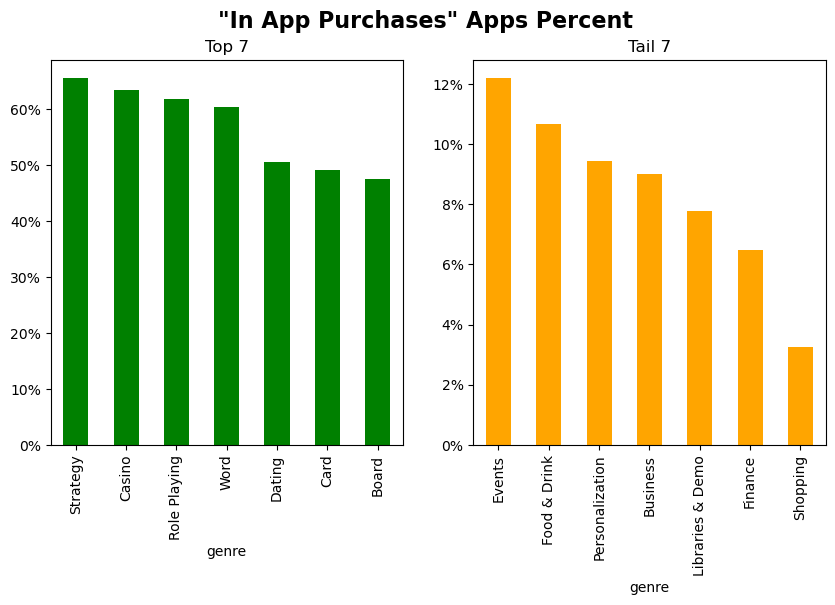

In [137]:
#Top and tail genres percentage of apps that have in app prices.
#some genres have many apps that offer in app purchases, like strategy (60%), 
#while these are a minority of apps in other genres like finance (6%)

income_method1 = income_method.sort_values(by="in_app_price_%", ascending = False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.suptitle('"In App Purchases" Apps Percent', fontsize=16, fontweight='bold')

from matplotlib.ticker import FuncFormatter
income_method1["in_app_price_%"].head(7).plot.bar(ax=axes[0], color = 'green')
axes[0].set_title("Top 7")
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

income_method1["in_app_price_%"].tail(7).plot.bar(ax=axes[1], color = 'orange')
axes[1].set_title("Tail 7")
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

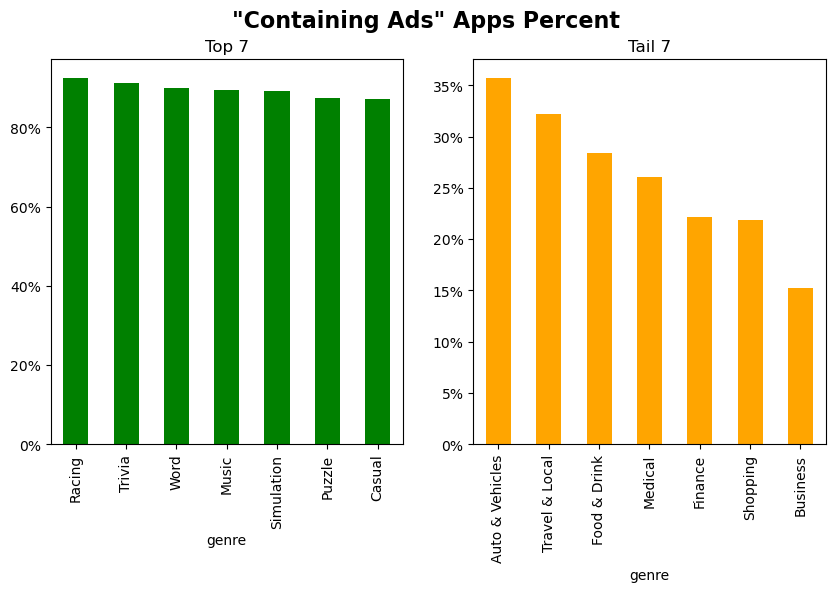

In [136]:
#Top and tail genres percentage of apps that contain in app ads.
income_method2 = income_method.sort_values(by="contains_ads_%", ascending = False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.suptitle('"Containing Ads" Apps Percent', fontsize=16, fontweight='bold')

income_method2["contains_ads_%"].head(7).plot.bar(ax=axes[0], color = 'green')
axes[0].set_title("Top 7")
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

income_method2["contains_ads_%"].tail(7).plot.bar(ax=axes[1], color='orange')
axes[1].set_title("Tail 7")
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

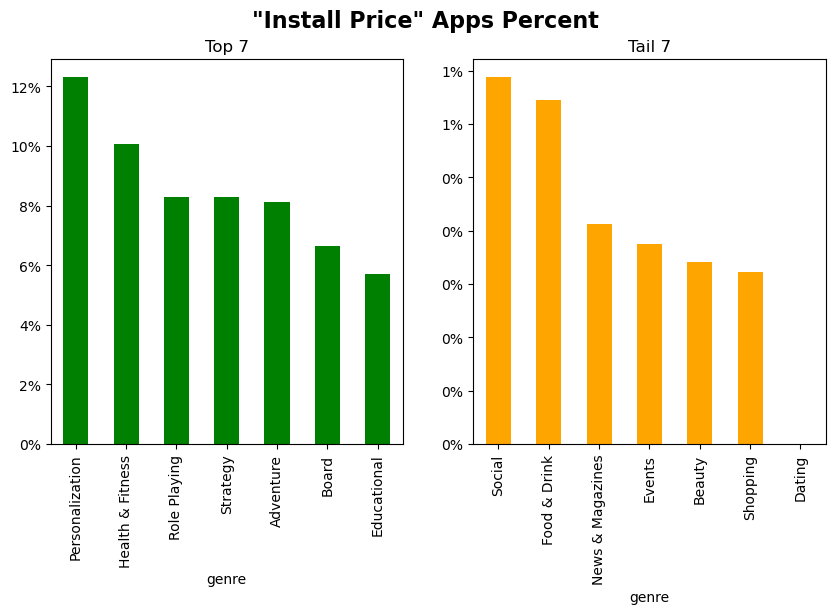

In [149]:
#Top and tail genres percentage of apps with install price
income_method3 = income_method.sort_values(by="install_price_%", ascending = False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.xticks(rotation=np.deg2rad(45))
plt.suptitle('"Install Price" Apps Percent', fontsize=16, fontweight='bold')
plt.tick_params(axis='x', rotation=100)

income_method3["install_price_%"].head(7).plot.bar(ax=axes[0], color = 'green')
axes[0].set_title("Top 7")
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

income_method3["install_price_%"].tail(7).plot.bar(ax=axes[1], color = 'orange')
axes[1].set_title("Tail 7")
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

Text(0.5, 1.0, 'Installs Count by Genre (In Millions)')

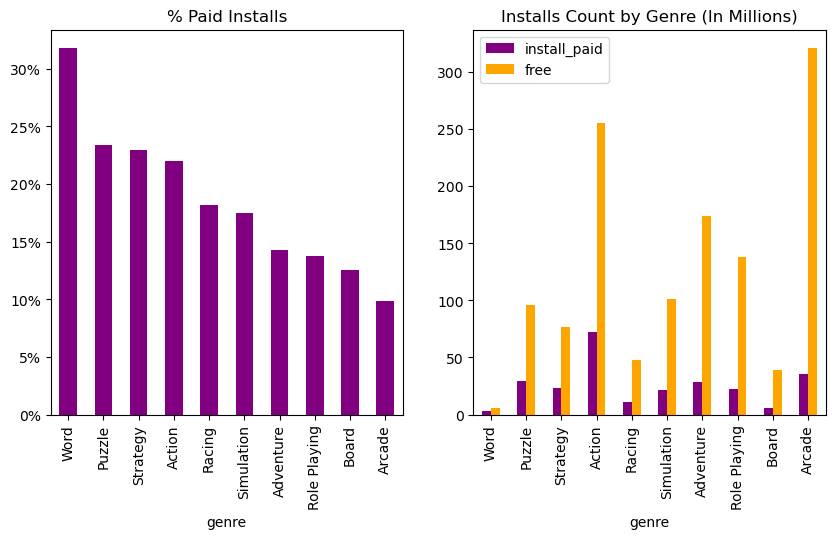

In [141]:
#how much of app installs in a certain genre are paid?
#users willingness to pay for an app in a certain genre
paid =clean_apps[(clean_apps["price"]> 0)]

paid_genre = paid.groupby("genre")["minInstalls"].agg(["sum"]).sort_values(by="genre", ascending=False)/1000000
free_genre = free.groupby("genre")["minInstalls"].agg(["sum"]).sort_values(by="genre", ascending=False)/1000000

payment_genre = pd.DataFrame()
payment_genre["install_paid"] = paid_genre
payment_genre["free"] = free_genre
payment_genre["paid%"]= paid_genre/(free_genre+paid_genre)

payment_genre = payment_genre.sort_values(by="paid%", ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
from matplotlib.ticker import FuncFormatter

payment_genre["paid%"].head(10).plot.bar(ax=axes[0], color = 'purple')
axes[0].set_title("% Paid Installs")
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

payment_genre[["install_paid", "free"]].head(10).plot.bar(ax=axes[1], color = ('purple', 'orange'))
axes[1].set_title("Installs Count by Genre (In Millions)")



Text(0.5, 1.0, '2022 Released: Installs Count (In Millions)')

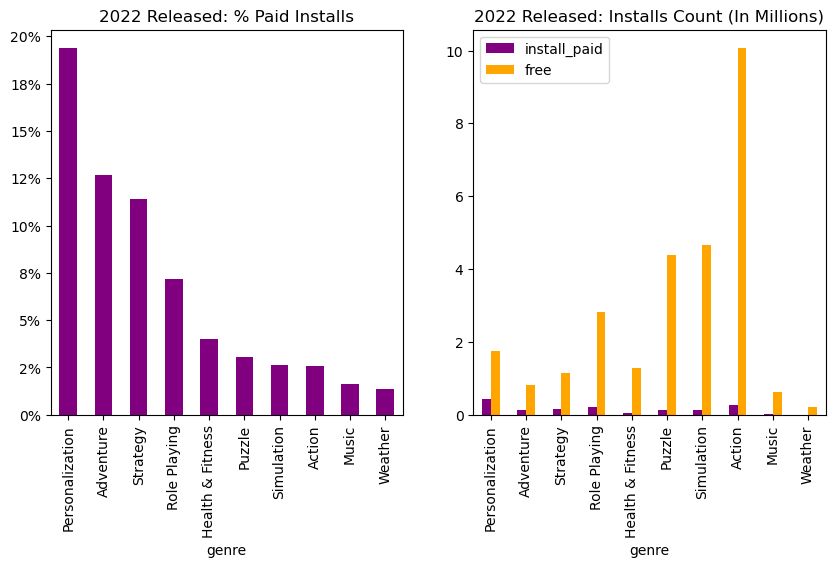

In [167]:
#same only for 2022 released apps:
#users willingness to pay for a new, released in 2022 app, per genre.

paid2022= clean_apps[(clean_apps["price"]> 0) & (clean_apps["releaseDate"].dt.year==2022)]
free2022= free[free["releaseDate"].dt.year==2022]

paid_genre2022 = paid2022.groupby("genre")["minInstalls"].agg(["sum"]).sort_values(by="genre", ascending=False)/1000000
free_genre2022 = free2022.groupby("genre")["minInstalls"].agg(["sum"]).sort_values(by="genre", ascending=False)/1000000

payment_genre2022 = pd.DataFrame()
payment_genre2022["install_paid"] = paid_genre2022
payment_genre2022["free"] = free_genre2022
payment_genre2022["paid%"]= paid_genre2022/(free_genre2022+paid_genre2022)

payment_genre2022 = payment_genre2022.sort_values(by="paid%", ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
from matplotlib.ticker import FuncFormatter


payment_genre2022["paid%"].head(10).plot.bar(ax=axes[0], color = 'purple')
axes[0].set_title("2022 Released: % Paid Installs")
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

payment_genre2022[["install_paid", "free"]].head(10).plot.bar(ax=axes[1], color = ('purple', 'orange'))
axes[1].set_title("2022 Released: Installs Count (In Millions)")




In [ ]:
clean_apps[(clean_apps["genre"]=="Word") & clean_apps["price"]>0]

9.99

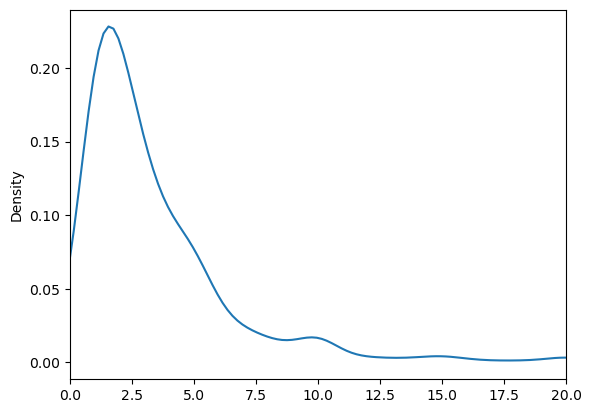

In [252]:
apps_prices= clean_apps[clean_apps["price"]>0]["price"]
cutoff = apps_prices.quantile(0.95)
#95% of the paid apps prices range between 0.2 and 10. distribution:
price_distribution = apps_prices.plot.kde().set_xlim(0,20)

In [222]:
#Minimum revenue per genre:
#total income from installations per genre

def percentile_70(x):
    return x.quantile(0.7)

paid_apps = clean_apps[clean_apps["price"]>0]
list_func = ["sum", "count", "mean", "median", "std"]
list_func.append(lambda x: x.quantile(0.7)) #add function that returns 70% revenue value.
list_func.append(lambda x: x.quantile(0.9)) #add function that returns 90% revenue value.
format_func = lambda x: "{:,.0f}".format(x)

install_income = paid_apps.groupby("genre")["min_install_revenue"].agg(list_func).sort_index(ascending=False)
install_income["count%_of_genre"] = (income_method["install_price_%"]*100).sort_index(ascending=False)
install_income = install_income.sort_values(by="sum", ascending=False)

formatted_install_income = install_income.applymap(format_func)
formatted_install_income

#it seems like the median is much lower then the mean for apps revenue. meaning that there are some very benfecial apps at the top.
#but mid apps in each cathegory range between 39,990 (Parenting) and 990 (Libraries & Demo). doesnt seem very benefecial.


,sum,count,mean,median,std,<lambda_0>,<lambda_1>,count%_of_genre
genre,,,,,,,,
Action,"167,007,170",398,"419,616","19,900","2,261,121","79,405","594,000",4
Arcade,"137,728,730",408,"337,570","9,950","3,767,911","39,400","299,000",4
Tools,"108,544,505","1,554","69,848","4,990","340,581","19,900","99,900",4
Music & Audio,"97,599,150",631,"154,674","4,990","1,495,797","19,900","149,500",3
Adventure,"95,815,210",652,"146,956","19,900","513,189","39,900","299,000",8
Puzzle,"84,291,165",690,"122,161","9,900","534,941","24,950","199,000",4
Role Playing,"83,298,615",528,"157,763","19,950","524,648","59,900","349,500",8
Simulation,"79,670,770",431,"184,851","19,900","607,582","59,900","349,000",3
Strategy,"75,079,200",395,"190,074","19,900","619,969","59,900","399,300",8


Text(0.5, 1.0, 'Tail 7')

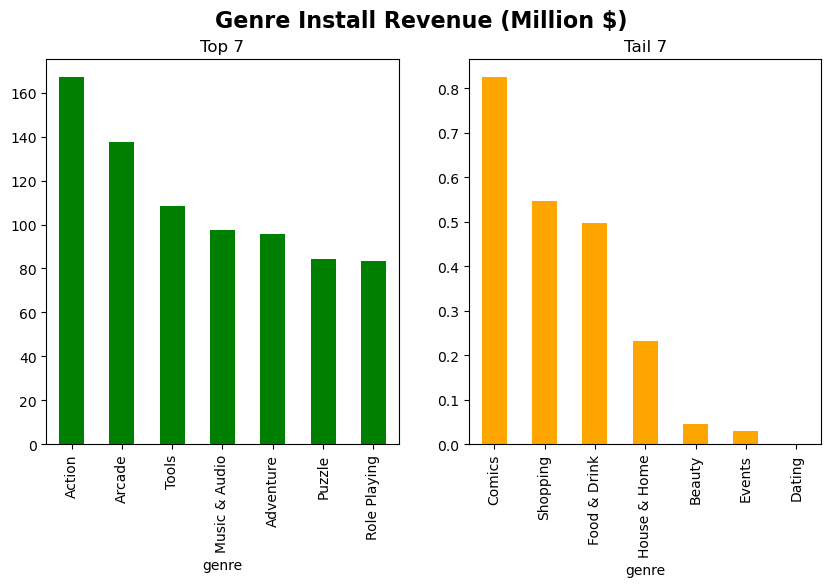

In [247]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.suptitle('Genre Install Revenue (Million $)', fontsize=16, fontweight='bold')

((install_income["sum"])/1000000).sort_values(ascending=False).head(7).plot.bar(ax=axes[0], color = 'green')
axes[0].set_title("Top 7")

((install_income["sum"])/1000000).sort_values(ascending=False).tail(7).plot.bar(ax=axes[1], color = 'orange')
axes[1].set_title("Tail 7")

Text(0.5, 1.0, 'Tail 7')

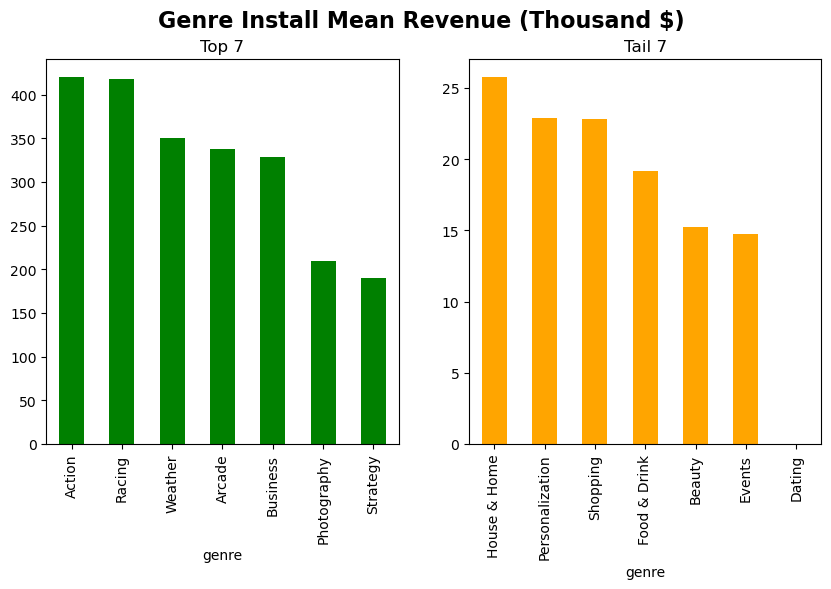

In [246]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.suptitle('Genre Install Mean Revenue (Thousand $)', fontsize=16, fontweight='bold')

((install_income["mean"])/1000).sort_values(ascending=False).head(7).plot.bar(ax=axes[0], color = 'green')
axes[0].set_title("Top 7")

((install_income["mean"])/1000).sort_values(ascending=False).tail(7).plot.bar(ax=axes[1], color = 'orange')
axes[1].set_title("Tail 7")

Text(0.5, 1.0, 'Tail 7')

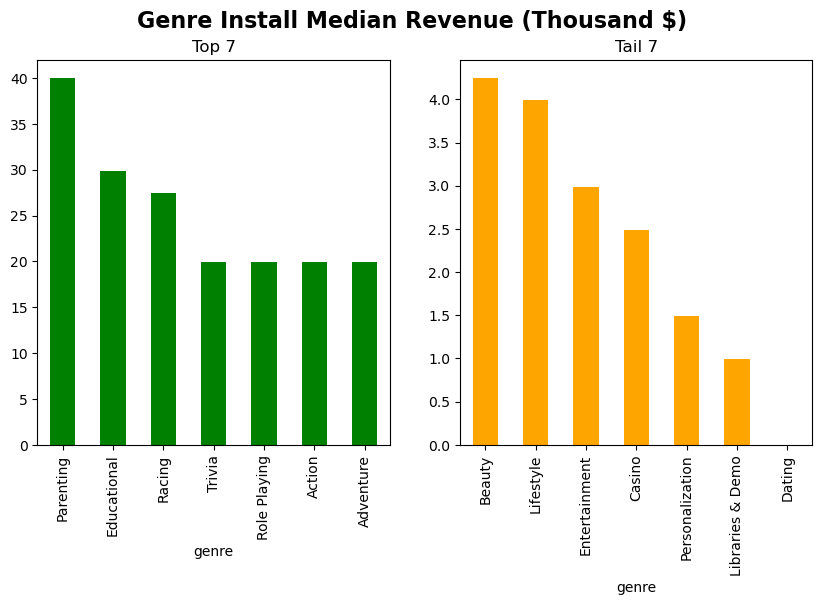

In [248]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.suptitle('Genre Install Median Revenue (Thousand $)', fontsize=16, fontweight='bold')

((install_income["median"])/1000).sort_values(ascending=False).head(7).plot.bar(ax=axes[0], color = 'green')
axes[0].set_title("Top 7")

((install_income["median"])/1000).sort_values(ascending=False).tail(7).plot.bar(ax=axes[1], color = 'orange')
axes[1].set_title("Tail 7")

Text(0.5, 1.0, 'Tail 7')

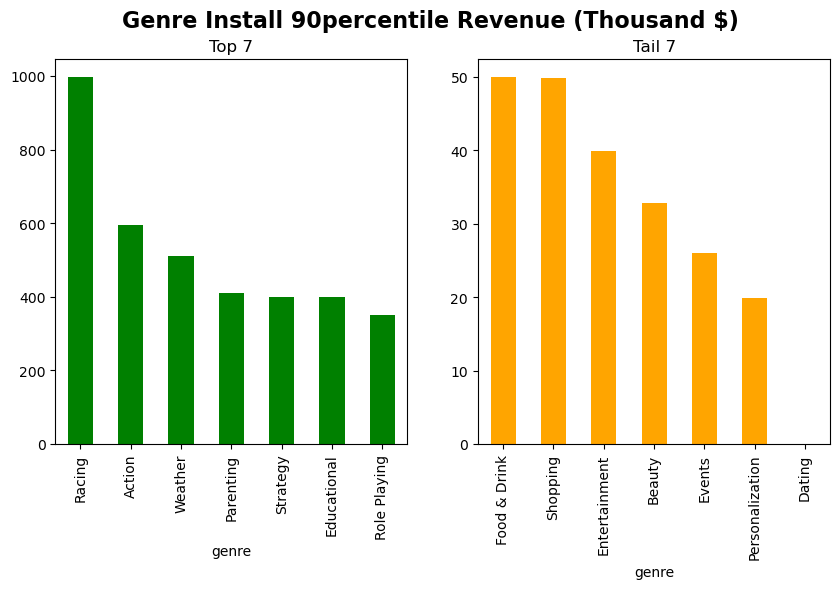

In [250]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.suptitle('Genre Install 90percentile Revenue (Thousand $)', fontsize=16, fontweight='bold')

((install_income["<lambda_1>"])/1000).sort_values(ascending=False).head(7).plot.bar(ax=axes[0], color = 'green')
axes[0].set_title("Top 7")

((install_income["<lambda_1>"])/1000).sort_values(ascending=False).tail(7).plot.bar(ax=axes[1], color = 'orange')
axes[1].set_title("Tail 7")

In [ ]:
#scores per category for install price apps